# Font Recognetion

### Classical method
    - BOVW 
    - SIFT
    - K-Means clustring
    - SVM || Random Forest


## SIFT


In [65]:
# Load Data
data_classes, classes_values, data_values, total_data_count = joblib.load("words_img_values.pkl")
print('Total number of Classes: ', len(data_classes), '- Total number of images: ', total_data_count, len(data_values))

Total number of Classes:  5 - Total number of images:  94485 94485


In [20]:
# Init SIFT
sift_object = cv2.xfeatures2d.SIFT_create()

In [32]:
# Increase `Image` borders by `bordersize` for each side with value 255 (White)
def border_image(image, bordersize):
    border = cv2.copyMakeBorder(
        image,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=[255, 255, 255]
    )
    return border

In [75]:
# Extract + Descripe Featuers 
images_featuers_descriptions = []
for img in tqdm(data_values[:20000]):
    try:
        clear_output(wait=True)
        # Make a border for the image since some times SIFT fails with small images
        # by expermint making border 100+ works very well
        image = border_image(img, 100)
        # Feature Extracting
        key_points, descrptions = sift_object.detectAndCompute(image, None)
        # Some times Sift doesn't detect featuers,
        # but the arrays must have constant length so it won't blow up
        if descrptions is None:
            descrptions = np.array([[0.0] * 128])
            
        images_featuers_descriptions.append(descrptions)
        
    except NameError:
            print('error :', cv, imagePath)





100%|██████████| 20000/20000 [02:05<00:00, 158.91it/s]


## K-Means

In [76]:
# Vstack all images featuers
vstacked_descriptions = images_featuers_descriptions[0]
for description in tqdm(images_featuers_descriptions[1:]):
    clear_output(wait=True)
    vstacked_descriptions = np.vstack((vstacked_descriptions, description))
    
# Set data type to float32
vstacked_descriptions = np.array(vstacked_descriptions, "float32")
print(len(vstacked_descriptions))

100%|██████████| 19999/19999 [03:18<00:00, 100.58it/s]

49478


In [77]:
# Mesure Clusters
from scipy.cluster.vq import kmeans, vq
k = 100
code_book, variance = kmeans(vstacked_descriptions, k, 1)

In [88]:
# Setting up Code Book
images_bow_featuers = np.zeros((len(images_featuers_descriptions), k), "float32")
for i in tqdm(range(len(images_featuers_descriptions))):
    clear_output(wait=True)
    words, distance = vq(images_featuers_descriptions[i], code_book)
    for w in words:
        images_bow_featuers[i][w] += 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [90]:
# Calculate TF-IDF
nbr_occerances = np.sum((images_bow_featuers > 0) * 1, axis=0)
idf = np.array(np.log((1.0 * len(images_featuers_descriptions) + 1) / (1.0 * nbr_occerances + 1)), 'float32')

In [91]:
images_idf_featuers = np.multiply(images_bow_featuers, idf[np.newaxis, :])

In [92]:
print(len(images_bow_featuers))

20000


## SVM

In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

std_slr = StandardScaler().fit(images_bow_featuers)
images_idf_featuers = std_slr.transform(images_idf_featuers)

In [97]:
clf = LinearSVC(max_iter=100000)

In [98]:
#Random forest
#from sklearn.ensemble import  RandomForestClassifier
#clf = RandomForestClassifier(n_estimators= 5000, random_state= 100)

In [99]:
clf.fit(images_idf_featuers, np.array(classes_values[:20000]))

KeyboardInterrupt: 

In [ ]:
# Save Model
print('dumping')
joblib.dump((clf, classes, stdSlr, k, voc, idf), "pkls/model.pkl", compress=3)

## Testing

In [ ]:
# Testing
test_Features = np.multiply(test_Features, idf[np.newaxis, :])
test_Features = stdSlr.transform(test_Features)

In [ ]:
true_class = [classes_names[i] for i in images_classes]
prediction = [classes_names[i] for i in clf.predict(test_Features)]

print("true class= ", true_class)
print("prediction= ", prediction)

In [ ]:
def show_confusion_matrix(cm):
    plt.matshow(cm)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.show()

accuracy = accuracy_score(true_class, prediction)
cm = confusion_matrix(true_class, prediction)

show_confusion_matrix(cm)

# Data Mangemnet

## Read Data paths

In [62]:
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import numpy as np
from IPython.display import clear_output

In [34]:
# Data Set Path which is words images with differant type of fonts
data_path = '/Users/malikziq/DataSets/APIT_Arabic_Words_Images/'

# Data file extention
extention = '.png'

# Data Dic, Total number of items in dic, classes in the dic
data_dic = {}
total_count = 0
data_classes = []
data_values = []
classes_values = []



In [35]:
print(glob(data_path + '*'))

['/Users/malikziq/DataSets/APIT_Arabic_Words_Images/deco_type_naskh', '/Users/malikziq/DataSets/APIT_Arabic_Words_Images/advirtising_bold', '/Users/malikziq/DataSets/APIT_Arabic_Words_Images/andalus', '/Users/malikziq/DataSets/APIT_Arabic_Words_Images/diwani_letter', '/Users/malikziq/DataSets/APIT_Arabic_Words_Images/municode_sara']


In [36]:
for each in glob(data_path + '*'):
    # Take the last file name (Class) from the path 
    word = each.split("/")[-1]
    print(word)
    
    # Set new Class in the data_dic
    data_dic[word] = []
    data_classes.append(word)
    
    # Get data for each class
    for root, dirs, files in os.walk(each):
        for file in files:
            if file.lower().endswith(extention):
                imagePath = os.path.join(root, file)
                data_dic[word].append(imagePath)
                total_count += 1


deco_type_naskh
advirtising_bold
andalus
diwani_letter
municode_sara


In [37]:
print(data_dic.keys())
print(data_classes)

dict_keys(['deco_type_naskh', 'advirtising_bold', 'andalus', 'diwani_letter', 'municode_sara'])
['deco_type_naskh', 'advirtising_bold', 'andalus', 'diwani_letter', 'municode_sara']


## Read The Images

/Users/malikziq/DataSets/APIT_Arabic_Words_Images/deco_type_naskh/DecoTypeNaskh_6_Bold/set104/Image_6_DecoType Naskh Extensions_8093.png


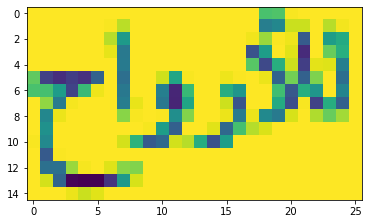

In [38]:
# Gray Level Image
print(data_dic['deco_type_naskh'][800])
test_image = cv2.imread(data_dic['deco_type_naskh'][707], 0)


plt.imshow(test_image)

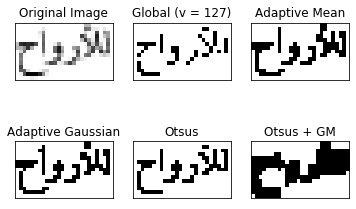

In [39]:
img = test_image
ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

# Otsu's thresholding
ret2,th4 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th5 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


titles = ['Original Image', 'Global (v = 127)',
            'Adaptive Mean', 'Adaptive Gaussian','Otsus','Otsus + GM']
images = [img, th1, th2, th3, th4, th5]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [ ]:
class_id=0
for cls in tqdm(data_classes, leave=False):
    for each_path in tqdm(data_dic[cls], leave=True):
        # Read Image in GRAY LEVEL
        new_image = cv2.imread(each_path,0)
        # Threshold using Otsu's
        ret, th = cv2.threshold(new_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # Append Image to the list
        data_values.append(th)
        # Append Class Lable
        classes_values.append(class_id)
        
    
    class_id += 1
        
        

In [73]:
# used to save pickle data file
#joblib.dump((data_classes, classes_values, data_values, total_count), "words_img_values.pkl", compress=3)

['words_img_values.pkl']

In [19]:
print('Total images = ', total_count)

Total images =  94485


In [1]:
!conda info --envs

# conda environments:
#
base                  *  /Users/malikziq/opt/anaconda3
FountTypeDetection       /Users/malikziq/opt/anaconda3/envs/FountTypeDetection



In [2]:
!pip3 freeze

alabaster==0.7.12
anaconda-client==1.7.2
anaconda-navigator==1.9.12
anaconda-project==0.8.3
appnope==0.1.0
appscript==1.0.1
asn1crypto==1.0.1
astroid==2.3.1
astropy==3.2.2
atomicwrites==1.3.0
attrs==19.2.0
Babel==2.7.0
backcall==0.1.0
backports.functools-lru-cache==1.5
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.8.0
bitarray==1.0.1
bkcharts==0.2
bleach==3.1.0
bokeh==1.3.4
boto==2.49.0
Bottleneck==1.2.1
certifi==2019.9.11
cffi==1.12.3
chardet==3.0.4
Click==7.0
cloudpickle==1.2.2
clyent==1.2.2
colorama==0.4.1
conda==4.8.2
conda-build==3.18.9
conda-package-handling==1.6.0
conda-verify==3.4.2
contextlib2==0.6.0
cryptography==2.7
cycler==0.10.0
Cython==0.29.13
cytoolz==0.10.0
dask==2.5.2
decorator==4.4.0
defusedxml==0.6.0
distributed==2.5.2
docutils==0.15.2
entrypoints==0.3
et-xmlfile==1.0.1
fastcache==1.1.0
filelock==3.0.12
Flask==1.1.1
fsspec==0.5.2
future==0.17.1
gevent==1.4.0
glob2==0.7
gmpy2==2.0.8